# Założenia Projektowe

Celem projektu jest analiza wpływu na rozgrywkę w Leauge of Legends różnych zmiennych takie jak statystyki bohaterów, przedmiotów, statystyk w meczu na zwycięstwo w grze.

Pod uwagę będą brane takie dane jak KDA, ilość zdobytego złota w grze, wysokość dywizji, statystyki za wizjęm długość gry itp.

# Instalacja bibliotek

In [42]:
!pip install datasets
#!pip install ydata-profiling
#!pip install --upgrade pandas-profiling
!pip install --upgrade scikit-learn
!pip install tqdm

# Import bibliotek

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pointbiserialr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
from sklearn.neural_network import MLPClassifier

# Import danych i edycja danych


In [44]:
df_match = pd.read_parquet('/content/2023-07-19_2023-07-29_euw.parquet')
df_match

,controlWardsPlaced,goldPerMinute,kda,killParticipation,multikills,teamDamagePercentage,turretPlatesTaken,visionScoreAdvantageLaneOpponent,visionScorePerMinute,assistMePings,...,visionWardsBoughtInGame,wardsPlaced,win,matchId,gameCreation,gameStartTime,gameDuration,retrieveTime,division,tier
0,2,520.357365,3.285714,0.450980,3,0.232296,4,0.753906,0.748549,1,...,3,10,True,EUW1_6506383413,2023-07-19 20:59:24.237,2023-07-19 20:59:50.883,34.633333,2023-07-20 21:19:10.003176,I,GOLD
1,0,377.706442,0.909091,0.500000,1,0.251139,0,-0.241053,0.411896,7,...,0,7,False,EUW1_6506383450,2023-07-19 20:58:51.720,2023-07-19 20:59:32.016,23.300000,2023-07-20 21:30:18.937703,I,SILVER
2,3,274.133056,2.750000,0.468085,0,0.052141,1,-0.085795,1.899461,0,...,5,30,False,EUW1_6506401339,2023-07-19 21:07:00.928,2023-07-19 21:08:16.597,36.950000,2023-07-20 21:17:06.729827,I,GOLD
3,0,361.480076,0.750000,0.250000,0,0.190013,0,0.860469,0.564643,0,...,0,6,False,EUW1_6506403146,2023-07-19 21:05:31.761,2023-07-19 21:06:14.618,27.366667,2023-07-20 21:42:29.167645,I,DIAMOND
4,0,279.567249,0.142857,0.125000,0,0.152350,0,-0.230271,0.454447,0,...,0,2,False,EUW1_6506414638,2023-07-19 21:09:03.373,2023-07-19 21:09:35.339,15.983333,2023-07-20 21:28:07.120870,I,GOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493695,1,419.219913,4.333333,0.464286,0,0.217949,3,0.245594,0.623430,0,...,1,7,True,EUW1_6525191645,2023-07-28 23:57:22.131,2023-07-28 23:59:14.354,21.566667,2023-07-29 00:29:12.104413,II,SILVER
493696,2,588.137864,5.750000,0.605263,1,0.326172,3,0.670012,1.303563,2,...,2,10,True,EUW1_6525197799,2023-07-29 00:07:26.402,2023-07-29 00:07:43.341,24.633333,2023-07-29 00:37:31.237715,II,DIAMOND
493697,1,493.062135,5.666667,0.515152,1,0.322037,2,2.082895,0.854626,4,...,1,8,True,EUW1_6525207205,2023-07-29 00:19:38.846,2023-07-29 00:20:13.754,24.983333,2023-07-29 00:56:26.063773,III,PLATINUM
493698,1,322.433336,1.000000,0.307692,0,0.121339,0,-0.378085,0.562704,0,...,1,7,False,EUW1_6525229766,2023-07-29 00:38:36.029,2023-07-29 00:41:03.736,20.616667,2023-07-29 01:15:36.860624,IV,DIAMOND


In [45]:
df_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493700 entries, 0 to 493699
Data columns (total 40 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   controlWardsPlaced                493700 non-null  Int64         
 1   goldPerMinute                     493700 non-null  float64       
 2   kda                               493700 non-null  float64       
 3   killParticipation                 486525 non-null  float64       
 4   multikills                        493700 non-null  Int64         
 5   teamDamagePercentage              492455 non-null  float64       
 6   turretPlatesTaken                 493700 non-null  Int64         
 7   visionScoreAdvantageLaneOpponent  483992 non-null  float64       
 8   visionScorePerMinute              493700 non-null  float64       
 9   assistMePings                     493700 non-null  Int64         
 10  championName                    

In [46]:
unikalne_wartosci = set(df_match['win'])
unikalne_wartosci

{False, True}

In [47]:
df_review = df_match[['teamPosition']]
df_review

,teamPosition
0,MIDDLE
1,MIDDLE
2,UTILITY
3,BOTTOM
4,JUNGLE
...,...
493695,MIDDLE
493696,BOTTOM
493697,MIDDLE
493698,BOTTOM


In [48]:
df_match['teamPosition'] = df_match['teamPosition'].replace('', np.nan)
#df_match = df_match.dropna(subset=['teamPosition'])

In [49]:
df_match['rank'] = df_match.apply(lambda row: row['tier'] + ' ' + row['division'], axis=1)

In [50]:
print(df_match['teamPosition'].unique())

['MIDDLE' 'UTILITY' 'BOTTOM' 'JUNGLE' 'TOP' nan]


In [51]:
df_match['win'] = df_match['win'].astype(int)
df_match['firstBloodAssist'] = df_match['firstBloodAssist'].astype(int)
df_match['firstBloodKill'] = df_match['firstBloodKill'].astype(int)
df_match['rank'] = df_match['rank'].replace({
    'DIAMOND I': 1,
    'DIAMOND II': 2,
    'DIAMOND III': 3,
    'DIAMOND IV': 4,
    'GOLD I': 5,
    'GOLD II': 6,
    'GOLD III': 7,
    'GOLD IV': 8,
    'PLATINUM I': 9,
    'PLATINUM II': 10,
    'PLATINUM III': 11,
    'PLATINUM IV': 12,
    'SILVER I': 13,
    'SILVER II': 14,
    'SILVER III': 15,
    'SILVER IV': 16
})
df_match['teamPosition'] = df_match['teamPosition'].replace({
    'BOTTOM': 1,
    'JUNGLE': 2,
    'MIDDLE': 3,
    'TOP': 4,
    'UTILITY': 5,
})

In [52]:
df_match = df_match.drop(['matchId', 'gameCreation', 'gameStartTime', 'retrieveTime', 'division', 'tier'], axis=1)

In [53]:
df_match = df_match.dropna()

In [54]:
df_match

,controlWardsPlaced,goldPerMinute,kda,killParticipation,multikills,teamDamagePercentage,turretPlatesTaken,visionScoreAdvantageLaneOpponent,visionScorePerMinute,assistMePings,...,totalHeal,totalHealsOnTeammates,totalTimeCCDealt,tripleKills,visionScore,visionWardsBoughtInGame,wardsPlaced,win,gameDuration,rank
0,2,520.357365,3.285714,0.450980,3,0.232296,4,0.753906,0.748549,1,...,1611,0,82,0,25,3,10,1,34.633333,5
1,0,377.706442,0.909091,0.500000,1,0.251139,0,-0.241053,0.411896,7,...,1285,0,0,0,9,0,7,0,23.300000,13
2,3,274.133056,2.750000,0.468085,0,0.052141,1,-0.085795,1.899461,0,...,4054,0,222,0,70,5,30,0,36.950000,5
3,0,361.480076,0.750000,0.250000,0,0.190013,0,0.860469,0.564643,0,...,1405,0,9,0,15,0,6,0,27.366667,1
4,0,279.567249,0.142857,0.125000,0,0.152350,0,-0.230271,0.454447,0,...,9309,0,73,0,7,0,2,0,15.983333,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493695,1,419.219913,4.333333,0.464286,0,0.217949,3,0.245594,0.623430,0,...,723,0,108,0,13,1,7,1,21.566667,14
493696,2,588.137864,5.750000,0.605263,1,0.326172,3,0.670012,1.303563,2,...,4126,0,36,0,32,2,10,1,24.633333,2
493697,1,493.062135,5.666667,0.515152,1,0.322037,2,2.082895,0.854626,4,...,5328,0,96,0,21,1,8,1,24.983333,11
493698,1,322.433336,1.000000,0.307692,0,0.121339,0,-0.378085,0.562704,0,...,1577,0,68,0,11,1,7,0,20.616667,4


In [55]:
df_match.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 483892 entries, 0 to 493699
Data columns (total 35 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   controlWardsPlaced                483892 non-null  Int64  
 1   goldPerMinute                     483892 non-null  float64
 2   kda                               483892 non-null  float64
 3   killParticipation                 483892 non-null  float64
 4   multikills                        483892 non-null  Int64  
 5   teamDamagePercentage              483892 non-null  float64
 6   turretPlatesTaken                 483892 non-null  Int64  
 7   visionScoreAdvantageLaneOpponent  483892 non-null  float64
 8   visionScorePerMinute              483892 non-null  float64
 9   assistMePings                     483892 non-null  Int64  
 10  championName                      483892 non-null  object 
 11  dangerPings                       483892 non-null  I

In [56]:
#df_ranked = pd.read_csv('high_diamond_ranked_10min.csv')
#del df_ranked['gameId']
#df_ranked

In [57]:
#df_ranked.info()

In [58]:
#unikalne_nazwy_kolumn = df_ranked.columns.tolist()
#unikalne_nazwy_kolumn

In [59]:
#df_champ = pd.read_csv('LoL-Champions.csv')
#del df_champ['Id']
#df_champ

In [60]:
#df_champ.info()

In [61]:
#unikalne_nazwy_kolumn = df_champ.columns.tolist()
#unikalne_nazwy_kolumn

In [62]:
#unikalne_wartosci = set(df_champ['Class'])
#unikalne_wartosci

In [63]:
#df_champ2 = pd.read_csv('lol_champion_stats_en.csv', encoding='latin1', delimiter=';')
#df_champ2

In [64]:
#df_items = pd.read_csv('LOL_items_stats.csv', delimiter=';')
#df_items

In [65]:
#df_champ2.info()

# Analiza danych

In [66]:
#df_champ.corr()

In [67]:
#df_champ2.corr()

In [68]:
# Ustalamy listę kolumn z DataFrame
kolumny = df_match.columns

# Inicjalizujemy dwie puste listy, jedna na dane binarne, a druga na inne dane liczbowe
dane_binarne = []
inne_dane = []

for kolumna in kolumny:
    # Sprawdzamy, czy wszystkie wartości w kolumnie są binarne (0 lub 1)
    if df_match[kolumna].isin([0, 1]).all():
        dane_binarne.append(kolumna)
    else:
        inne_dane.append(kolumna)

# Wyświetlamy wyniki
print("Kolumny zawierające dane binarne:")
for kolumna in dane_binarne:
    print(kolumna)

print("\nKolumny zawierające inne dane liczbowe:")
for kolumna in inne_dane:
    print(kolumna)

Kolumny zawierające dane binarne:
firstBloodAssist
firstBloodKill
win

Kolumny zawierające inne dane liczbowe:
controlWardsPlaced
goldPerMinute
kda
killParticipation
multikills
teamDamagePercentage
turretPlatesTaken
visionScoreAdvantageLaneOpponent
visionScorePerMinute
assistMePings
championName
dangerPings
deaths
goldEarned
kills
largestKillingSpree
onMyWayPings
pentaKills
quadraKills
teamId
teamPosition
totalDamageDealtToChampions
totalDamageTaken
totalHeal
totalHealsOnTeammates
totalTimeCCDealt
tripleKills
visionScore
visionWardsBoughtInGame
wardsPlaced
gameDuration
rank


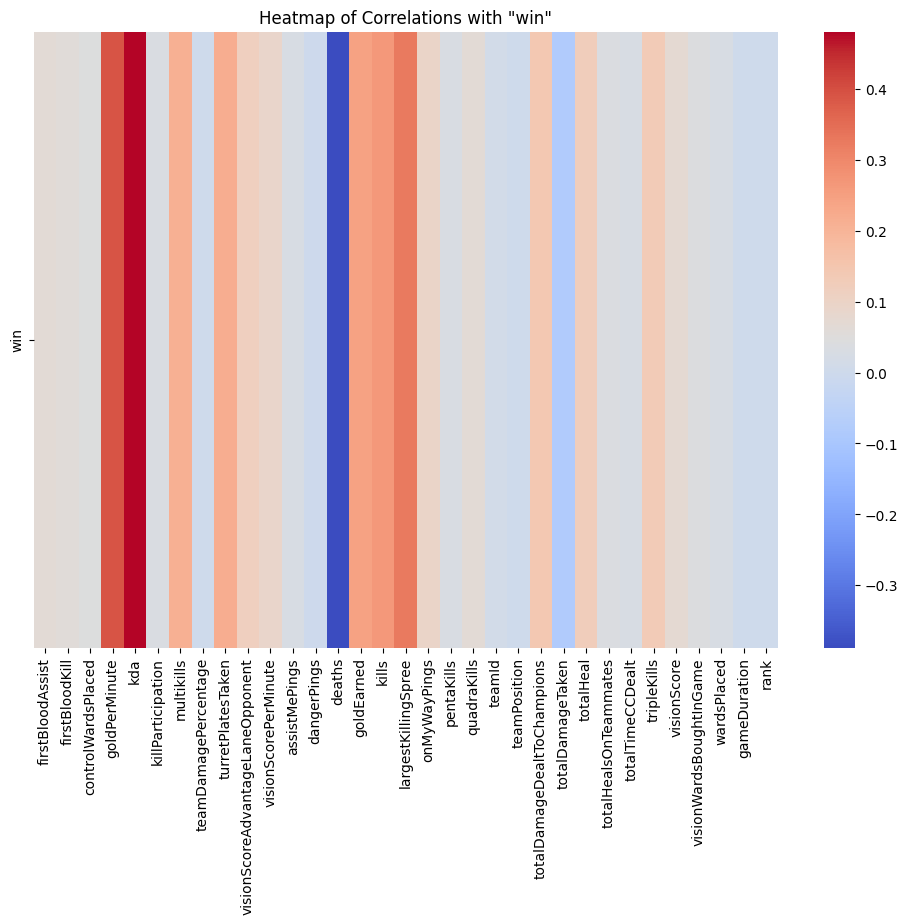

In [69]:

# Kolumny binarne
binarne_kolumny = ['firstBloodAssist', 'firstBloodKill']

# Kolumny liczbowe
liczbowe_kolumny = [
    'controlWardsPlaced', 'goldPerMinute', 'kda', 'killParticipation',
    'multikills', 'teamDamagePercentage', 'turretPlatesTaken',
    'visionScoreAdvantageLaneOpponent', 'visionScorePerMinute',
    'assistMePings', 'dangerPings', 'deaths', 'goldEarned',
    'kills', 'largestKillingSpree', 'onMyWayPings', 'pentaKills',
    'quadraKills', 'teamId', 'teamPosition', 'totalDamageDealtToChampions',
    'totalDamageTaken', 'totalHeal', 'totalHealsOnTeammates',
    'totalTimeCCDealt', 'tripleKills', 'visionScore',
    'visionWardsBoughtInGame', 'wardsPlaced', 'gameDuration', 'rank'
]

# Inicjalizujemy DataFrame dla macierzy korelacji
correlation_matrix = pd.DataFrame(index=binarne_kolumny + liczbowe_kolumny, columns=['win'])

# Wypełniamy macierz korelacji wartościami korelacji punktowej (phi)
for column in binarne_kolumny:
    correlation, _ = pointbiserialr(df_match['win'], df_match[column])
    correlation_matrix.at[column, 'win'] = correlation

# Wypełniamy macierz korelacji wartościami p-wartości
for column in liczbowe_kolumny:
    correlation, p_value = pointbiserialr(df_match['win'], df_match[column])
    correlation_matrix.at[column, 'win'] = correlation

# Konwertujemy p-wartości na liczby
correlation_matrix['win'] = correlation_matrix['win'].astype(float)

# Ustawienie rozmiaru wykresu
plt.figure(figsize=(12, 8))

# Użyj Seaborn do wygenerowania mapy cieplnej
sns.heatmap(correlation_matrix.transpose(), fmt=".4f", cmap='coolwarm')

# Wyświetlenie tytułu
plt.title('Heatmap of Correlations with "win"')

# Wyświetlenie wykresu
plt.show()

In [70]:
correlation_matrix

,win
firstBloodAssist,6.467163e-02
firstBloodKill,5.964296e-02
controlWardsPlaced,4.605746e-02
goldPerMinute,3.898147e-01
kda,4.813494e-01
killParticipation,3.451660e-02
multikills,2.097667e-01
teamDamagePercentage,-6.081562e-05
turretPlatesTaken,2.169564e-01
visionScoreAdvantageLaneOpponent,1.160937e-01


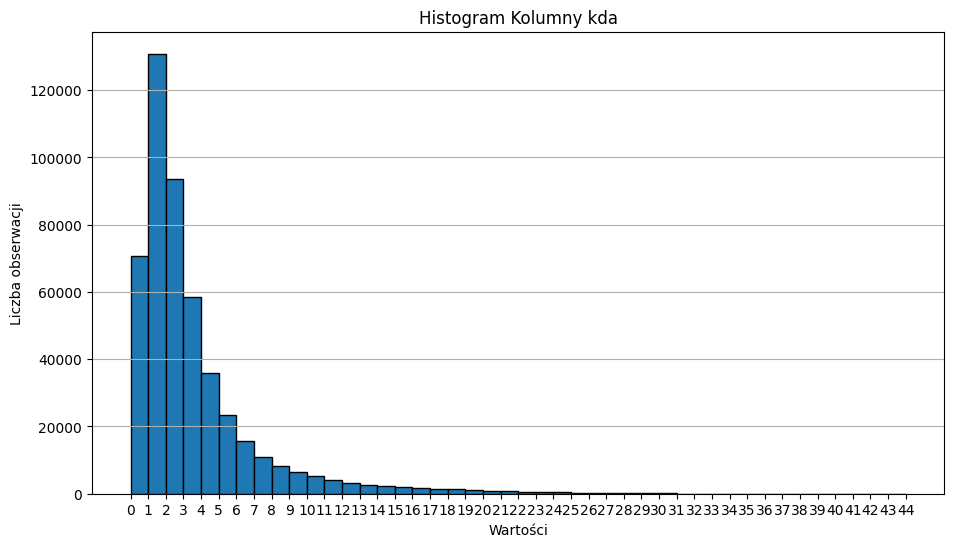

In [71]:
column_name = 'kda'
column_values = df_match[column_name]

plt.figure(figsize=(11, 6))
plt.hist(column_values, bins=range(int(min(column_values)), int(max(column_values)) + 1), edgecolor='k')


plt.grid(True, axis='y')
plt.xticks(range(int(min(column_values)), int(max(column_values)) + 1))
plt.title(f'Histogram Kolumny {column_name}')
plt.xlabel('Wartości')
plt.ylabel('Liczba obserwacji')
plt.show()

In [72]:
#df_ranked.corr()

# Podział danych projektowych

In [73]:
y = df_match['win']
X = df_match[['kda', 'turretPlatesTaken', 'visionScoreAdvantageLaneOpponent', 'totalHeal']]

## REGRESJA LOGISTYCZNA

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Inicjalizacja i trening modelu
model = LogisticRegression(C=1.0, penalty='l2', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# Predykcja na zbiorze testowym
y_pred = model.predict(X_test)

# Ocena modelu
dokladnosc = accuracy_score(y_test, y_pred)
print(f'Dokładność modelu: {dokladnosc:.2f}')

# Raport klasyfikacji
print(classification_report(y_test, y_pred))

Dokładność modelu: 0.79
              precision    recall  f1-score   support

           0       0.76      0.85      0.80     60904
           1       0.83      0.73      0.77     60069

    accuracy                           0.79    120973
   macro avg       0.79      0.79      0.79    120973
weighted avg       0.79      0.79      0.79    120973



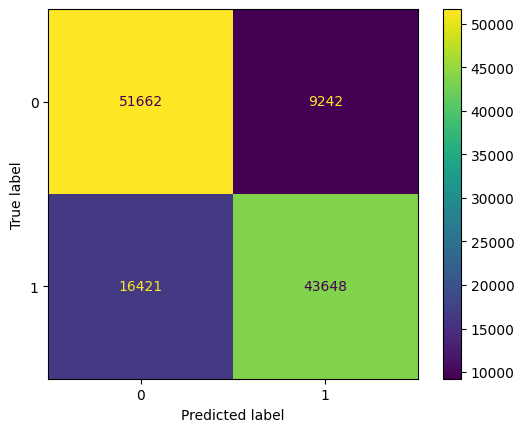

In [75]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

### OPTYMALIZACJA MODELU

In [76]:
# Inicjalizacja modelu
#model = LogisticRegression()

# Inicjalizacja RandomizedSearchCV
#random_search = RandomizedSearchCV(
#    estimator=model,
#    param_distributions= {
#        'C': [0.1, 1, 10, 100],  # Przykład wartości C
#        'penalty': ['l1', 'l2'],  # Możesz wybrać L1 lub L2
#        'solver': ['liblinear', 'lbfgs', 'saga'],  # Dostępne solwery
#        'max_iter': [100, 200],  # Przykład wartości max_iter
#        'class_weight': [None, 'balanced']  # Opcje dla wyrównania wag klas
#        },
#    n_iter=100,  # Liczba losowych próbek do wypróbowania
#    cv=5,  # Ilość podziałów walidacji krzyżowej
#    verbose=2,  # Wyświetlanie postępu
#    n_jobs=-1  # Użyj wszystkich dostępnych rdzeni CPU
#)

# Trenowanie modelu z wykorzystaniem najlepszych parametrów
#with tqdm(total=random_search.n_iter, desc="Przetwarzanie parametrów") as pbar:
#    random_search.fit(X_train, y_train)
#    pbar.update(1)

# Zapisz najlepsze parametry znalezione przez RandomizedSearchCV
#best_params = random_search.best_params_
#print("Najlepsze parametry:")
#print(best_params)

# Przewidywanie na zbiorze testowym
#y_pred = random_search.predict(X_test)

# Ocena modelu
#report = classification_report(y_test, y_pred)

# Wyświetl raport
#print("Raport klasyfikacji:")
#print(report)

In [77]:
#cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
#color = 'white'
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
#disp.plot()
#plt.show()

## RANDOM FOREST

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicjalizacja modelu Random Forest
model = RandomForestClassifier(n_estimators=25,  # Liczba drzew
                              max_depth=10,  # Maksymalna głębokość drzewa
                              min_samples_split=5,  # Minimalna liczba próbek do podziału
                              min_samples_leaf=2,  # Minimalna liczba próbek w liściu
                              max_features=0.5,  # Maksymalna liczba cech do rozważenia
                              random_state=42)

# Trenowanie modelu z wykorzystaniem tqdm
with tqdm(total=model.n_estimators, desc="Trenowanie modelu") as pbar:
    for i in range(model.n_estimators):
        model.set_params(warm_start=True, n_estimators=i+1)
        model.fit(X_train, y_train)
        pbar.update(1)

# Predykcja na zbiorze testowym
y_pred = model.predict(X_test)

# Raport klasyfikacji
report = classification_report(y_test, y_pred)

# Wyświetl raport
print("Raport klasyfikacji z użyciem Random Forest:")
print(report)

Trenowanie modelu: 100%|██████████| 25/25 [00:25<00:00,  1.02s/it]


Raport klasyfikacji z użyciem Random Forest:
              precision    recall  f1-score   support

           0       0.79      0.80      0.80     48697
           1       0.79      0.79      0.79     48082

    accuracy                           0.79     96779
   macro avg       0.79      0.79      0.79     96779
weighted avg       0.79      0.79      0.79     96779



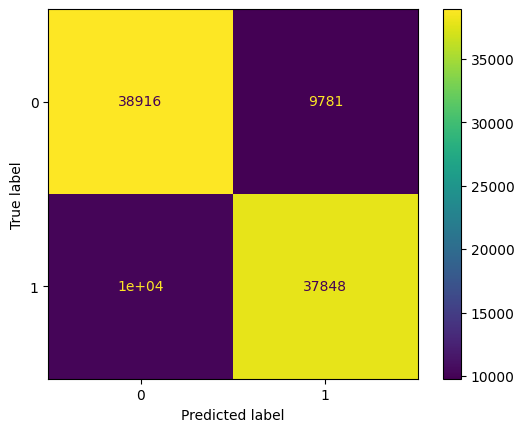

In [79]:
unique_labels = set(y_test)

cm = confusion_matrix(y_test, y_pred, labels=list(unique_labels))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(unique_labels))
disp.plot()
plt.show()

### OPTYMALIZACJA MODELU

In [80]:
# Inicjalizuj model Random Forest
#model = RandomForestClassifier()

# Inicjalizuj RandomizedSearchCV
#random_search = RandomizedSearchCV(
#    estimator=model,
#    param_distributions = {
#        "n_estimators": [int(x) for x in np.linspace(start=10, stop=50, num=5)],
#        "max_depth": [int(x) for x in np.linspace(5, 25, num=5)],
#        "min_samples_split": [2, 5, 10],
#        "min_samples_leaf": [1, 2, 4],
#        "max_features": ["auto", "sqrt", "log2"],
#        "bootstrap": [True, False]
#        },
#    n_iter=50,  # Liczba losowych próbek do wypróbowania
#    cv=5,  # Ilość podziałów walidacji krzyżowej
#    verbose=1,  # Wyświetlanie postępu
#    random_state=42,
#    n_jobs=-1  # Użyj wszystkich dostępnych rdzeni CPU
#)

# Trenuj model z przeszukiwaniem
#random_search.fit(X, y)

# Wyświetl najlepsze parametry znalezione przez RandomizedSearchCV
#print("Najlepsze parametry:")
#print(random_search.best_params_)

# Przewidywanie na zbiorze testowym za pomocą najlepszego modelu
#best_model = random_search.best_estimator_
#y_pred = best_model.predict(X_test)

# Ocena modelu
#report = classification_report(y_test, y_pred)

# Wyświetl raport klasyfikacji
#print("Raport klasyfikacji:")
#print(report)

## MLP

In [82]:
# Podział danych na zbiór treningowy, walidacyjny i testowy
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standaryzacja danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Tworzenie modelu sieci neuronowej
MLP = keras.Sequential([
    # Warstwa wejściowa
    keras.layers.Input(shape=(X_train.shape[1],)),

    # Warstwy ukryte
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),

    # Warstwa wyjściowa
    keras.layers.Dense(1, activation='sigmoid')
])

# Kompilacja modelu
MLP.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Trenowanie modelu
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = MLP.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Ocena modelu na danych testowych
y_pred = MLP.predict(X_test)
y_pred_binary = (y_pred > 0.5)  # Konwertowanie wyników na binarną klasyfikację

report = classification_report(y_test, y_pred_binary)

# Wyświetlenie raportu klasyfikacji
print("Classification Report:")
print(report)

Epoch 1/15
12098/12098 [==============================] - 54s 4ms/step - loss: 0.4431 - accuracy: 0.7918 - val_loss: 0.4459 - val_accuracy: 0.7897
Epoch 2/15
12098/12098 [==============================] - 56s 5ms/step - loss: 0.4404 - accuracy: 0.7930 - val_loss: 0.4457 - val_accuracy: 0.7900
Epoch 3/15
12098/12098 [==============================] - 60s 5ms/step - loss: 0.4400 - accuracy: 0.7931 - val_loss: 0.4441 - val_accuracy: 0.7914
Epoch 4/15
12098/12098 [==============================] - 60s 5ms/step - loss: 0.4398 - accuracy: 0.7929 - val_loss: 0.4436 - val_accuracy: 0.7908
Epoch 5/15
12098/12098 [==============================] - 47s 4ms/step - loss: 0.4395 - accuracy: 0.7933 - val_loss: 0.4444 - val_accuracy: 0.7916
Epoch 6/15
12098/12098 [==============================] - 48s 4ms/step - loss: 0.4396 - accuracy: 0.7935 - val_loss: 0.4441 - val_accuracy: 0.7910
Epoch 7/15
12098/12098 [==============================] - 46s 4ms/step - loss: 0.4394 - accuracy: 0.7934 - val_loss: 0

In [83]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [84]:
def plot_learning_curve(metric):
  plt.figure(figsize=(5,3))
  plt.plot(history.history[metric], 'black')
  plt.plot(history.history[f'val_{metric}'], 'blue')
  plt.legend([f'train {metric}', f'val {metric}'])
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.show()

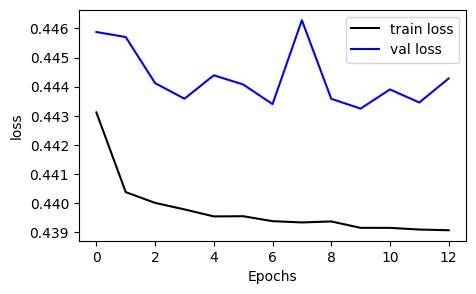

In [85]:
plot_learning_curve('loss')

### OPTYMALIZACJA MODELU

In [86]:
# W przyszłości będzie rozwijane

# Podsumowanie

Modele osiągenły swój pułap na poziiomie accuracy w okolicach 0.79 niezależnie od wybranej metody. W przyszłosci będę dodawał kolejne parametry do modelów pozwalające uzyskać lepsze prametry. W przypadku klasyfikacji pozwala to ocenić trafnie w wynik meczu w dowolnym momecie gry (minimum 5 minut potrzebne na zebranie danych) by z dużym prawdopodobieństwem oceniać która drużyna ma większe szanse na zwycięstwo.